## Part 1: Import Data and Drop Meaningless Columns

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
powerlifting = pd.read_csv('./usapl_ipf.csv')

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (11,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# drop meaningless columns
powerlifting.drop(['index', 'Unnamed: 0'], axis = 1, inplace=True)

## Part 1a: Drop Rows Missing information

In [4]:
# drop lifters who have no data for any lifts
useless_mask = (powerlifting['BestSquatKg'].isnull()) & (powerlifting['Squat1Kg'].isnull()) & \
(powerlifting['Squat2Kg'].isnull()) & (powerlifting['Squat3Kg'].isnull()) &\
(powerlifting['BestDeadliftKg'].isnull()) & (powerlifting['Deadlift1Kg'].isnull()) & \
(powerlifting['Deadlift2Kg'].isnull()) & (powerlifting['Deadlift3Kg'].isnull()) &\
(powerlifting['BestBenchKg'].isnull()) & (powerlifting['Bench1Kg'].isnull()) & \
(powerlifting['Bench2Kg'].isnull()) & (powerlifting['Bench3Kg'].isnull())


In [5]:
powerlifting = powerlifting[~useless_mask]

In [6]:
# drop rows where there is no weight class or bodyweight information
weight_mask = (powerlifting['WeightClassKg'].isnull()) & (powerlifting['BodyweightKg'].isnull())
powerlifting = powerlifting[~weight_mask]

## Part 2: Populate Bodyweight Column with Weight Class Information 
(Where Weight Class Has an Upper Limit)

In [7]:
powerlifting['BodyweightKg'].count()

69455

In [8]:
# mask where we have no Bodyweight information and the weight class has a lower limit. ie: '120+
# we cannot approximate a weight here since the weight can be anything over that limit, 
# whereas other weight classes have upper limits
search_upper_limit = ((powerlifting['WeightClassKg']=='120+') | (powerlifting['WeightClassKg']=='84+') | \
(powerlifting['WeightClassKg']=='140+') | (powerlifting['WeightClassKg']=='110+') | (powerlifting['WeightClassKg']=='125+') | \
(powerlifting['WeightClassKg']=='145+')| (powerlifting['WeightClassKg']=='90+')) & (powerlifting['BodyweightKg'].isnull())

In [9]:
powerlifting = powerlifting[~search_upper_limit]

In [10]:
# function to fill bodyweight with weight class where null (a good approximation)
def fill_bodyweight(row):
    if np.isnan(row['BodyweightKg']):
        row['BodyweightKg'] = pd.to_numeric(row['WeightClassKg'])
    return row
powerlifting = powerlifting.apply(fill_bodyweight, axis = 1)

## Part 3: Populate Age Column

In [11]:
# convert Date column to datetime:
powerlifting['Date'] = pd.to_datetime(powerlifting['Date'])

In [12]:
# extract year of competition:
powerlifting['Year'] = powerlifting['Date'].dt.year

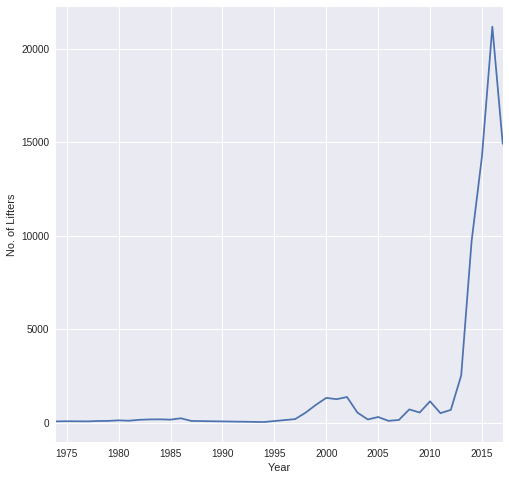

In [13]:
# graph of no. of lifters per year
plt.figure(figsize=(8, 8))
powerlifting.groupby('Year').count()['Sex'].plot()
plt.ylabel('No. of Lifters')
plt.show()

In [14]:
# function to calculate age if null
def calculate_age(row):
    if np.isnan(row['Age']) and np.isnan(row['BirthYear']) == False:
        row['Age'] = row['Year'] - row['BirthYear']
    return row 

powerlifting = powerlifting.apply(calculate_age, axis = 1)

In [15]:
display(powerlifting['Age'].isnull().sum())
display(powerlifting['Age'].std())

46539

13.009162867664569

## Part 4: Populate and Clean "Best"/"Total" Columns

In [16]:
powerlifting[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].describe()

,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
count,63799.000000,71413.000000,66897.000000,71695.000000
mean,170.303968,112.491702,191.379740,432.617230
std,66.023756,50.388674,61.139108,189.037466
min,-262.500000,-290.300000,-238.100000,17.500000
25%,117.500000,70.000000,142.500000,285.000000
50%,167.500000,110.000000,192.500000,430.000000
75%,212.500000,145.000000,235.000000,570.000000
max,505.000000,410.000000,420.000000,1272.500000


<p>as we can see, there are negative values for the "Best" lift columns, this means the lifter missed all three attempts at their lift. In powerlifting, three missed attempts means the lifter *"bombs out"* of the meet. We don't want these instances counting toward the BestLift column, so we need to change these to nulls. 

<p>also, there are totals within the TotalKg that were calculated off of one lift. (i.e. "Bench Only") these totals will on average be lower than the totals for 3 lifts. We want to treat this column like it only applies to people who have completed all three lifts.

In [17]:
powerlifting[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74629 entries, 0 to 75709
Data columns (total 4 columns):
BestSquatKg       63799 non-null float64
BestBenchKg       71413 non-null float64
BestDeadliftKg    66897 non-null float64
TotalKg           71695 non-null float64
dtypes: float64(4)
memory usage: 2.8 MB


In [18]:
# function to fill in negative best lifts with null values
def fix_best_lift(row):
    if row['BestSquatKg'] < 0:
        row['BestSquatKg'] = np.nan
    if row['BestBenchKg'] < 0:
        row['BestBenchKg'] = np.nan
    if row['BestDeadliftKg'] < 0:
        row['BestDeadliftKg'] = np.nan
    return row

In [19]:
powerlifting = powerlifting.apply(fix_best_lift, axis = 1)

In [20]:
# function to only calculate totals for lifters who have completed all three lifts
def fix_total(row):
    if np.isnan(row['BestSquatKg']) or np.isnan(row['BestBenchKg']) or np.isnan(row['BestDeadliftKg']):
        row['TotalKg'] = np.nan
    return row

In [21]:
powerlifting = powerlifting.apply(fix_total, axis = 1)

In [22]:
# check
powerlifting[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74629 entries, 0 to 75709
Data columns (total 4 columns):
BestSquatKg       63788 non-null float64
BestBenchKg       71402 non-null float64
BestDeadliftKg    66892 non-null float64
TotalKg           61950 non-null float64
dtypes: float64(4)
memory usage: 2.8 MB


In [23]:
powerlifting[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].describe()

,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
count,63788.000000,71402.000000,66892.000000,61950.000000
mean,170.360145,112.531323,191.406797,471.694686
std,65.886994,50.282754,61.059244,169.399009
min,13.600000,6.800000,15.900000,38.600000
25%,117.500000,70.000000,142.500000,330.000000
50%,167.500000,110.000000,192.500000,470.000000
75%,212.500000,145.000000,235.000000,587.500000
max,505.000000,410.000000,420.000000,1272.500000


## Part 5: Analyze Lifting Abilities across Age Groups

now our stats seem more accurate. the minimum values are still pretty low, the next step is to fix this by eliminating all teen and youth competitors (I believe they cannot lift as much.). We will first test to see if there is a difference using stats.

In [24]:
# divide dataframe by age 

old = powerlifting[powerlifting['Age'] > 17]

young = powerlifting[powerlifting['Age'] < 17]

unknown = powerlifting[powerlifting['Age'].isnull()]

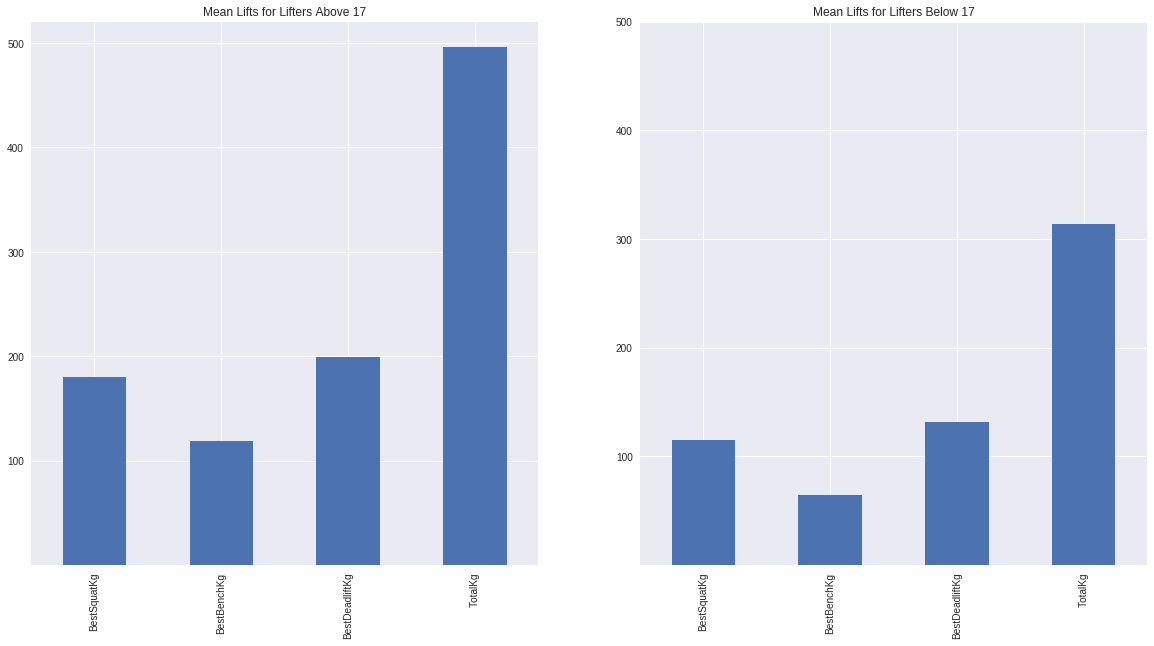

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

old[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].mean().plot(kind='bar',  ax=axes[0])
young[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].mean().plot(kind='bar', ax=axes[1])
ax1 = axes[0]
ax2 = axes[1]
ax1.set_title('Mean Lifts for Lifters Above 17')
ax2.set_title('Mean Lifts for Lifters Below 17')
for ax in axes:
    plt.sca(ax)
    plt.yticks((100, 200, 300, 400, 500))
    ax.yaxis.label.set_fontsize(16)
    ax.xaxis.label.set_fontsize(16)

In [38]:
print (old.shape)
print (young.shape)
print (unknown.shape)

(25432, 38)
(1499, 38)
(46539, 38)


In [39]:
# mask for null values in each category (since the ttest function cannot interpret them)

from scipy.stats import ttest_ind
old_total = old[old['TotalKg'].isnull()==False]['TotalKg'].values
old_bench = old[old['BestBenchKg'].isnull()==False]['BestBenchKg'].values
old_squat = old[old['BestSquatKg'].isnull()==False]['BestSquatKg'].values
old_dl = old[old['BestDeadliftKg'].isnull()==False]['BestDeadliftKg'].values

y_total = young[young['TotalKg'].isnull()==False]['TotalKg'].values
y_bench = young[young['BestBenchKg'].isnull()==False]['BestBenchKg'].values
y_squat = young[young['BestSquatKg'].isnull()==False]['BestSquatKg'].values
y_dl = young[young['BestDeadliftKg'].isnull()==False]['BestDeadliftKg'].values


In [40]:
# see if difference in means is statistically significant 
display(ttest_ind(old_total, y_total))
display(ttest_ind(old_bench, y_bench))
display(ttest_ind(old_squat, y_squat))
display(ttest_ind(old_dl, y_dl))

Ttest_indResult(statistic=37.158530665434114, pvalue=1.6288457423955389e-293)

Ttest_indResult(statistic=38.877308435688661, pvalue=0.0)

Ttest_indResult(statistic=33.729185425957937, pvalue=1.3142378758337333e-243)

Ttest_indResult(statistic=40.536573246710965, pvalue=0.0)

P-values are significantly small. This means there is a difference in the means between the two arrays. 
This could be for a variety of reasons but it means that we can take out the lifters in this category (Since we are looking for the upper limits of what a human can lift--all other calculations of these types of formulas have only used world records) Unfortunately, it doesn't mean we have weeded out every younger lifter...the "Age" column is very sparsely populated. There are other, more complicated ways to weed out these lifters. But we will first compare statistically

In [41]:
old[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].describe()

,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
count,22229.000000,24350.000000,23067.000000,21561.000000
mean,180.244347,118.887123,199.307341,495.803755
std,69.837967,52.411874,61.705292,176.564379
min,13.600000,9.100000,18.100000,40.800000
25%,125.000000,75.000000,147.500000,350.000000
50%,175.000000,115.000000,200.000000,492.500000
75%,222.500000,150.000000,242.500000,610.000000
max,505.000000,410.000000,420.000000,1272.500000


In [42]:
young[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].describe()

,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
count,1354.000000,1454.000000,1424.000000,1331.000000
mean,115.373811,64.963219,131.987591,313.686093
std,46.372341,28.994122,44.042620,113.548617
min,13.600000,9.100000,15.900000,38.600000
25%,83.125000,45.000000,102.500000,237.500000
50%,111.100000,60.000000,127.500000,302.500000
75%,140.000000,80.000000,155.000000,367.500000
max,320.000000,210.000000,290.000000,772.500000


In [43]:
unknown[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].describe()

,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
count,39138.000000,44472.000000,41307.000000,38020.000000
mean,167.210959,111.243091,189.761277,465.488185
std,63.100215,48.821892,60.094912,163.804378
min,15.000000,10.000000,20.000000,54.400000
25%,117.500000,68.000000,140.000000,325.000000
50%,165.000000,110.000000,192.500000,470.000000
75%,210.000000,142.500000,235.000000,582.500000
max,500.000000,401.500000,395.000000,1271.500000


In [44]:
# can we keep in our unknown ages? 
unknown_total = unknown[unknown['TotalKg'].isnull()==False]['TotalKg'].values
unknown_bench = unknown[unknown['BestBenchKg'].isnull()==False]['BestBenchKg'].values
unknown_squat = unknown[unknown['BestSquatKg'].isnull()==False]['BestSquatKg'].values
unknown_deadlift = unknown[unknown['BestDeadliftKg'].isnull()==False]['BestDeadliftKg'].values


In [45]:
# see if difference in means is statistically significant 
display(ttest_ind(old_total, unknown_total))
display(ttest_ind(old_bench, unknown_bench))
display(ttest_ind(old_squat, unknown_squat))
display(ttest_ind(old_dl, unknown_deadlift))

Ttest_indResult(statistic=21.099211845470748, pvalue=1.8568868485266156e-98)

Ttest_indResult(statistic=19.130572492057905, pvalue=2.2880242433327758e-81)

Ttest_indResult(statistic=23.648733579841085, pvalue=4.3356299495571405e-123)

Ttest_indResult(statistic=19.140503579867058, pvalue=1.9577023554852858e-81)

The P-values came back with a significant difference between the two groups this could possibly be due to younger lifters still being in the unknown age group. Some might not be referenced by age, but they could still be referenced by division. This is the next thing to check.

In [46]:
# find average age by division 
age_by_division = powerlifting.groupby('Division')['Age'].mean()

In [47]:
# turn into a dict with keys as division titles and values are average ages
age_division_mapped = dict(age_by_division)

In [48]:
# find keys where value is null and try to extrapolate an average age for each div
null_keys = []
for key in age_division_mapped.keys():
    if np.isnan(age_division_mapped[key]):
        null_keys.append(key)

In [49]:
len(null_keys)

194

In [50]:
# go through null_keys and see if any of them have information about the age group of their participants

age_division_mapped['14-15(T1)'] = 14.5
age_division_mapped['16-17(T2)'] = 16.5
age_division_mapped['18-17(T2)'] = 17.5
age_division_mapped['18-19(T3)'] = 18.5
age_division_mapped['20-23(Jr)'] = 21.5
age_division_mapped['35-39'] = 37
age_division_mapped['39-44 M1)'] = 41.5
age_division_mapped['39-44(M1)'] = 41.5
age_division_mapped['40-44'] = 42
age_division_mapped['40-45'] = 42.5
age_division_mapped['45-49'] = 47
age_division_mapped['45-49(M2)'] = 47
age_division_mapped['50-54'] = 52
age_division_mapped['55-59'] = 57
age_division_mapped['55-59(M4)'] = 57
age_division_mapped['60-64'] = 62
age_division_mapped['60-64(M5)'] = 62
age_division_mapped['65-69'] = 67
age_division_mapped['70-74'] = 72
age_division_mapped['75-79'] = 77
age_division_mapped['80-84'] = 82
age_division_mapped['J-20/23'] = 21.5
age_division_mapped['Junior [20-23]'] = 21.5
age_division_mapped['Master (45-49)'] = 47
age_division_mapped['Master (55-59)'] = 57
age_division_mapped['Master I [40-49]'] = 44.5
age_division_mapped['Master II [40-49]'] = 44.5
age_division_mapped['Master II [50-59]'] = 54.5
age_division_mapped['Master II [60-69]'] = 64.5
age_division_mapped['Master III [60-69]'] = 64.5
age_division_mapped['Masters (55-59)'] = 57
age_division_mapped['Masters II [50-59]'] = 54.5
age_division_mapped['T-16/17'] = 16.5
age_division_mapped['T-18/19'] = 18.5
age_division_mapped['Teen I [14-15]'] = 14.5
age_division_mapped['Teen II [16-17]'] = 16.5
age_division_mapped['Teen III [18-19]'] = 18.5
age_division_mapped['Teen [14-15]'] = 14.5
age_division_mapped['Teen [16-17]'] = 16.5

In [51]:
# check that appended divisions are in null_keys:
null_keys = []
for key in age_division_mapped.keys():
    if np.isnan(age_division_mapped[key]):
        null_keys.append(key)
len(null_keys)

155

In [52]:
def populate_age_by_division(row):
    if np.isnan(row['Age']) and row.isnull()['Division'] == False:
        KEY = row['Division']
        if np.isnan(age_division_mapped[KEY]) == False and (age_division_mapped[KEY] > 40 or age_division_mapped[KEY] < 23): 
            row['Age'] = age_division_mapped[KEY]
    return row 

In [53]:
powerlifting = powerlifting.apply(populate_age_by_division, axis = 1)

In [54]:
powerlifting.Age.isnull().sum()

24070

In [55]:
powerlifting.Age.describe()

count    50559.000000
mean        30.064889
std         14.275220
min          8.000000
25%         19.481953
50%         23.000000
75%         41.000000
max         90.000000
Name: Age, dtype: float64

In [56]:
powerlifting[(powerlifting['TotalKg'].isnull()==False) & (~powerlifting['Age'].isnull()) & \
             (~powerlifting['Sex'].isnull()) & (~powerlifting['BodyweightKg'].isnull())].shape

(42199, 38)

we were able to add about 20 thousand ages to our lifters (this mask originally yielded 23 thousand). Now we can either drop the teenagers or use this information for analysis

## Does "Equipment" effect Weight Lifted??

In [57]:
powerlifting.Equipment.value_counts()

Raw           52345
Single-ply    22284
Name: Equipment, dtype: int64

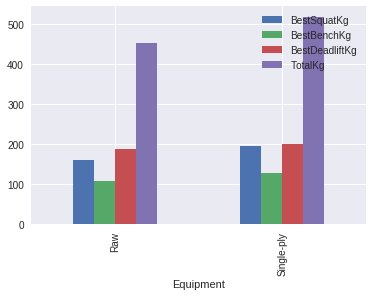

In [58]:
powerlifting.groupby(['Equipment']).mean()[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].plot(kind='bar')

In [59]:
raw = powerlifting[powerlifting['Equipment'] == 'Raw']

sp = powerlifting[powerlifting['Equipment'] == 'Single-ply']

In [63]:
display(raw[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].describe())
display(sp[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].describe())

,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
count,45296.000000,50358.000000,47838.00000,44119.000000
mean,159.936893,106.251025,187.65291,453.103341
std,58.022175,43.718779,58.79362,154.754960
min,15.000000,10.000000,20.00000,54.000000
25%,112.500000,67.500000,140.00000,320.000000
50%,160.000000,107.500000,190.00000,460.000000
75%,200.000000,138.300000,232.50000,570.000000
max,477.500000,285.000000,392.50000,1105.000000


,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
count,18492.000000,21044.000000,19054.000000,17831.000000
mean,195.891815,127.559987,200.831507,517.694997
std,76.226339,60.702432,65.467431,193.576547
min,13.600000,6.800000,15.900000,38.600000
25%,137.500000,77.500000,147.500000,357.500000
50%,187.500000,120.100000,200.000000,505.000000
75%,245.000000,167.500000,249.500000,645.000000
max,505.000000,410.000000,420.000000,1272.500000


In [64]:
raw_total = raw[raw['TotalKg'].isnull()==False]['TotalKg'].values
raw_bench = raw[raw['BestBenchKg'].isnull()==False]['BestBenchKg'].values
raw_squat = raw[raw['BestSquatKg'].isnull()==False]['BestSquatKg'].values
raw_dl = raw[raw['BestDeadliftKg'].isnull()==False]['BestDeadliftKg'].values

sp_total = sp[sp['TotalKg'].isnull()==False]['TotalKg'].values
sp_bench = sp[sp['BestBenchKg'].isnull()==False]['BestBenchKg'].values
sp_squat = sp[sp['BestSquatKg'].isnull()==False]['BestSquatKg'].values
sp_dl = sp[sp['BestDeadliftKg'].isnull()==False]['BestDeadliftKg'].values

In [65]:
# see if difference in means is statistically significant 
display(ttest_ind(raw_total, sp_total))
display(ttest_ind(raw_bench, sp_bench))
display(ttest_ind(raw_squat, sp_squat))
display(ttest_ind(raw_dl, sp_dl))

Ttest_indResult(statistic=-43.622651862019893, pvalue=0.0)

Ttest_indResult(statistic=-52.619276061722516, pvalue=0.0)

Ttest_indResult(statistic=-64.542410876216749, pvalue=0.0)

Ttest_indResult(statistic=-25.314975741497467, pvalue=1.009175629933086e-140)

## Part 6: Populate "Wilks" Score Column

- Judges of powerlifting competitions need a way to determine *Relative Strength*, or how much a lifter lifts relative to their bodyweight.  the Wilks score is handy for measuring how a 52 kg girl lifted compared to a 65 kg man. 
- Functions provided by <a href = "http://www.openpowerlifting.org/">OpenPowerlifting.org</a>

In [66]:
# openpowerlifting functions for Wilks Score

def wilksCoeff(a, b, c, d, e, f, x):
    return 500 / (a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5)

def wilksCoeffMen(x): # Where x is BodyweightKg.
    a = -216.0475144
    b = 16.2606339
    c = -0.002388645
    d = -0.00113732
    e = 7.01863E-06
    f = -1.291E-08
    return wilksCoeff(a, b, c, d, e, f, x)

def wilksCoeffWomen(x): # Where x is BodyweightKg.
    a = 594.31747775582
    b = -27.23842536447
    c = 0.82112226871
    d = -0.00930733913
    e = 0.00004731582
    f = -0.00000009054
    return wilksCoeff(a, b, c, d, e, f, x)

def wilks(isMale, bodyweightKg, totalKg):
    if isMale:
        return wilksCoeffMen(bodyweightKg) * totalKg
    return wilksCoeffWomen(bodyweightKg) * totalKg

In [67]:
# function written by me
def fill_wilks(row):
    """Takes a row of a dataframe and calculates the wilks score"""
    weight = row['BodyweightKg']
    total = row['TotalKg']
    if row['Sex'] == 'M':
        male = True
    else:
        male = False
    return wilks(male, weight, total)

In [68]:
powerlifting['calcWilks'] = powerlifting.apply(fill_wilks, axis=1)

In [69]:
# save cleaned data (just in case)
#powerlifting.to_pickle('./powerlifting_clean.p')

In [72]:
women = powerlifting[powerlifting['Sex'] == 'F']
men = powerlifting[powerlifting['Sex'] == 'M']

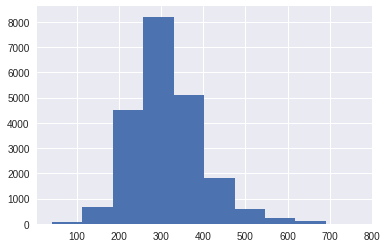

In [78]:
women['TotalKg'].hist()

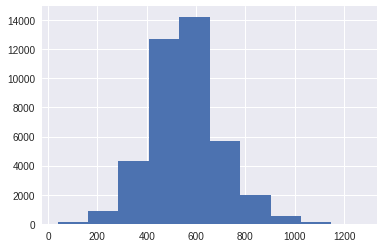

In [82]:
men['TotalKg'].hist()

In [88]:
powerlifting.Age.describe()

count    50559.000000
mean        30.064889
std         14.275220
min          8.000000
25%         19.481953
50%         23.000000
75%         41.000000
max         90.000000
Name: Age, dtype: float64

In [117]:
# create a dictionary to look at correlations after doing plotting
dict_of_correlations = {}

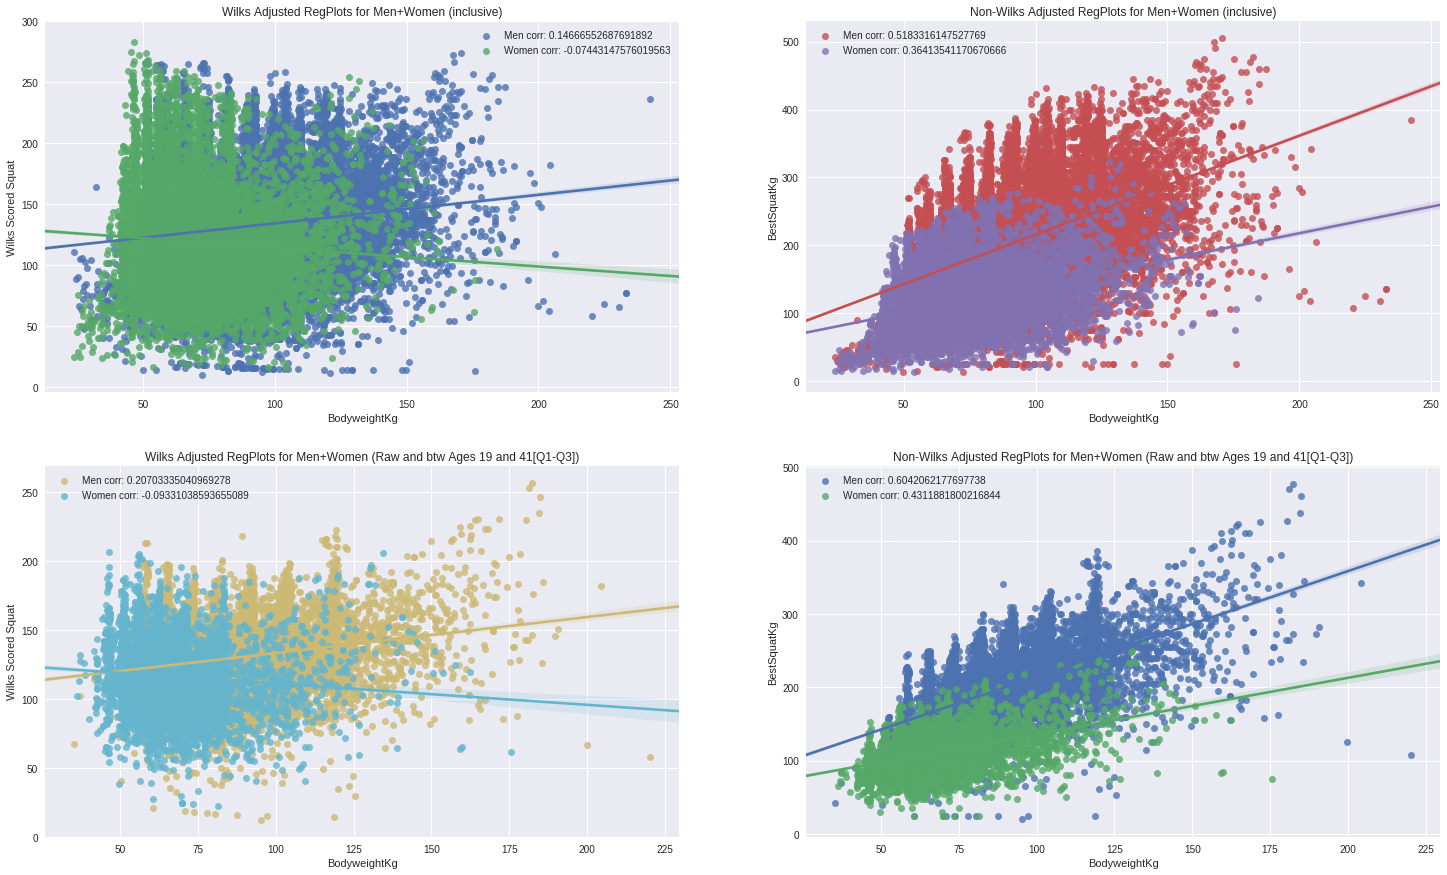

In [118]:
# Plot squat by wilks adjusted squat
squat = powerlifting[powerlifting['BestSquatKg'].isnull() == False]

# separate data into men and women 
women = squat[squat['Sex'] == 'F']
men = squat[squat['Sex'] == 'M']

# create data to plot
x = men.BodyweightKg
y = wilks(True, x, men.BestSquatKg)

w = women.BodyweightKg
t = wilks(False, w, women.BestSquatKg)

xa = men.BodyweightKg
ya = men.BestSquatKg

wa = women.BodyweightKg
ta = women.BestSquatKg 

# squat within Q1-Q3 of Age and only Raw 

selective_mask = (squat['Equipment'] == 'Raw') & (squat['Age'] > 19) & (squat['Age'] < 41)
squat_selective = squat[selective_mask]

# separate data into men and women 
womena = squat_selective[squat_selective['Sex'] == 'F']
mena = squat_selective[squat_selective['Sex'] == 'M']

# create data to plot
xb = mena.BodyweightKg
yb = wilks(True, xb, mena.BestSquatKg)

wb = womena.BodyweightKg
tb = wilks(False, wb, womena.BestSquatKg)

xab = mena.BodyweightKg
yab = mena.BestSquatKg

wab = womena.BodyweightKg
tab = womena.BestSquatKg 

# get correlations 
cor1m = np.corrcoef(x, y)[0][1]
cor1w = np.corrcoef(w, t)[0][1]
cor2m = np.corrcoef(xa, ya)[0][1]
cor2w = np.corrcoef(wa, ta)[0][1]
cor3m = np.corrcoef(xb, yb)[0][1]
cor3w = np.corrcoef(wb, tb)[0][1]
cor4m = np.corrcoef(xab, yab)[0][1]
cor4w = np.corrcoef(wab, tab)[0][1]

dict_of_correlations['squat'] = {
    'adjustedm': cor1m,
    'adjustedw': cor1w,
    'nonadjustedm': cor2m,
    'nonadjustedw': cor2w,
    'adjustedselectivem': cor3m,
    'adjustedselectivew': cor3w,
    'nonadjustedselectivem': cor4m,
    'nonadjustedselectivew': cor4w
}

# plot data

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))


sns.regplot(x, y, ax=axes[0][0], label='Men corr: {}'.format(cor1m))
sns.regplot(w, t, ax=axes[0][0], label='Women corr: {}'.format(cor1w))
axes[0][0].legend()
axes[0][0].set_ylabel("Wilks Scored Squat")
axes[0][0].set_title('Wilks Adjusted RegPlots for Men+Women (inclusive)')

sns.regplot(xa, ya, ax=axes[0][1], label='Men corr: {}'.format(cor2m))
sns.regplot(wa, ta, ax=axes[0][1], label='Women corr: {}'.format(cor2w))
axes[0][1].legend()
axes[0][1].set_title('Non-Wilks Adjusted RegPlots for Men+Women (inclusive)')

sns.regplot(xb, yb, ax=axes[1][0], label='Men corr: {}'.format(cor3m))
sns.regplot(wb, tb, ax=axes[1][0], label='Women corr: {}'.format(cor3w))
axes[1][0].legend()
axes[1][0].set_ylabel("Wilks Scored Squat")
axes[1][0].set_title('Wilks Adjusted RegPlots for Men+Women (Raw and btw Ages 19 and 41[Q1-Q3])')

sns.regplot(xab, yab, ax=axes[1][1], label='Men corr: {}'.format(cor4m))
sns.regplot(wab, tab, ax=axes[1][1], label='Women corr: {}'.format(cor4w))
axes[1][1].legend()
axes[1][1].set_title('Non-Wilks Adjusted RegPlots for Men+Women (Raw and btw Ages 19 and 41[Q1-Q3])')
plt.show()

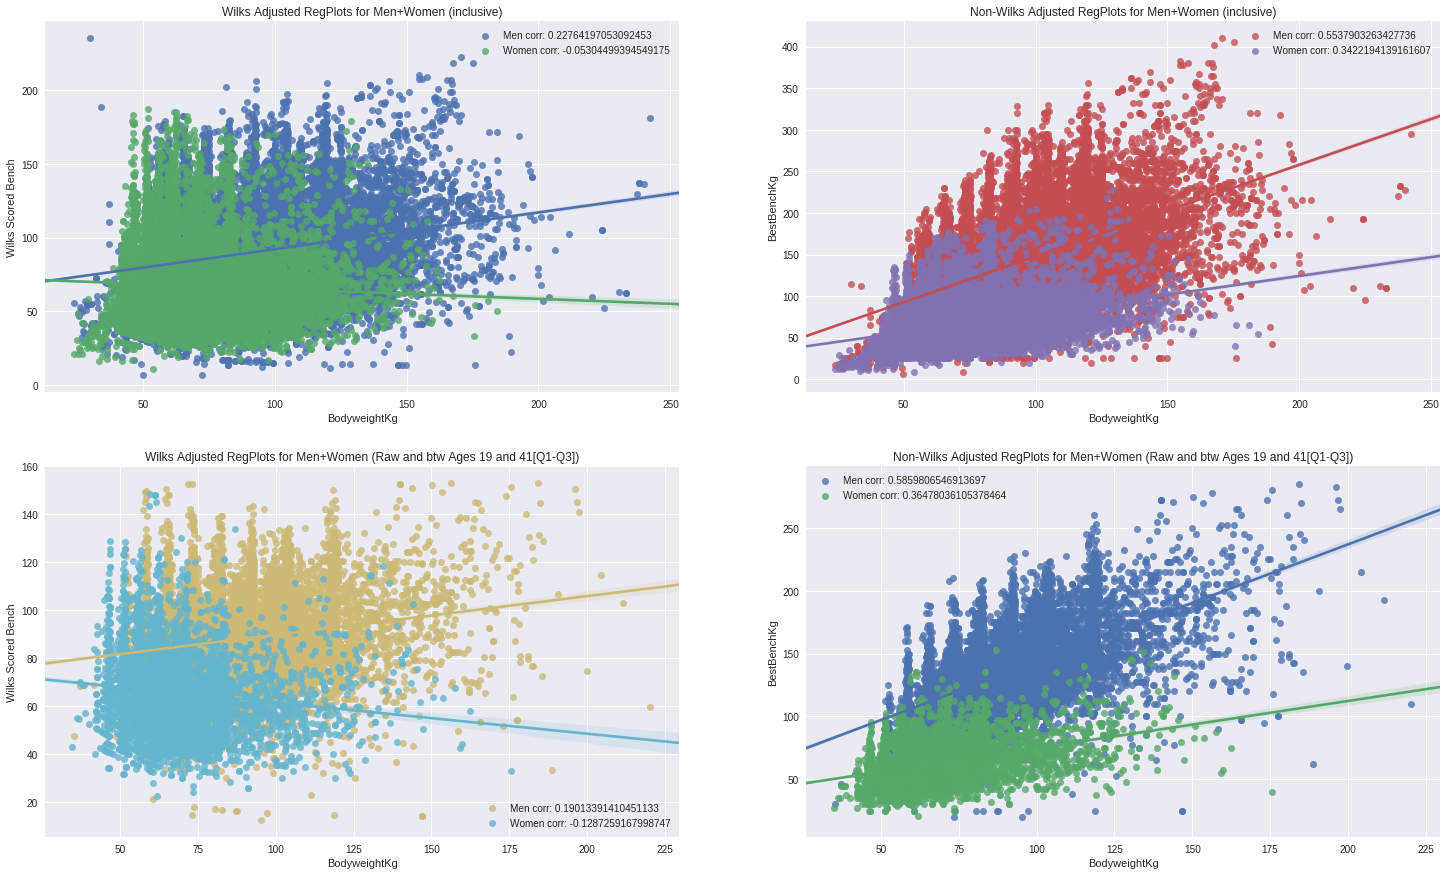

In [120]:
# Plot bench by wilks adjusted bench
bench = powerlifting[powerlifting['BestBenchKg'].isnull() == False]

# separate data into men and women 
women = bench[bench['Sex'] == 'F']
men = bench[bench['Sex'] == 'M']

# create data to plot
x = men.BodyweightKg
y = wilks(True, x, men.BestBenchKg)

w = women.BodyweightKg
t = wilks(False, w, women.BestBenchKg)

xa = men.BodyweightKg
ya = men.BestBenchKg

wa = women.BodyweightKg
ta = women.BestBenchKg 

# bench within Q1-Q3 of Age and only Raw 

selective_mask = (bench['Equipment'] == 'Raw') & (bench['Age'] > 19) & (bench['Age'] < 41)
bench_selective = bench[selective_mask]

# separate data into men and women 
womena = bench_selective[bench_selective['Sex'] == 'F']
mena = bench_selective[bench_selective['Sex'] == 'M']

# create data to plot
xb = mena.BodyweightKg
yb = wilks(True, xb, mena.BestBenchKg)

wb = womena.BodyweightKg
tb = wilks(False, wb, womena.BestBenchKg)

xab = mena.BodyweightKg
yab = mena.BestBenchKg

wab = womena.BodyweightKg
tab = womena.BestBenchKg 

# get correlations 
cor1m = np.corrcoef(x, y)[0][1]
cor1w = np.corrcoef(w, t)[0][1]
cor2m = np.corrcoef(xa, ya)[0][1]
cor2w = np.corrcoef(wa, ta)[0][1]
cor3m = np.corrcoef(xb, yb)[0][1]
cor3w = np.corrcoef(wb, tb)[0][1]
cor4m = np.corrcoef(xab, yab)[0][1]
cor4w = np.corrcoef(wab, tab)[0][1]

dict_of_correlations['bench'] = {
    'adjustedm': cor1m,
    'adjustedw': cor1w,
    'nonadjustedm': cor2m,
    'nonadjustedw': cor2w,
    'adjustedselectivem': cor3m,
    'adjustedselectivew': cor3w,
    'nonadjustedselectivem': cor4m,
    'nonadjustedselectivew': cor4w
}

# plot data

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))


sns.regplot(x, y, ax=axes[0][0], label='Men corr: {}'.format(cor1m))
sns.regplot(w, t, ax=axes[0][0], label='Women corr: {}'.format(cor1w))
axes[0][0].legend()
axes[0][0].set_ylabel("Wilks Scored Bench")
axes[0][0].set_title('Wilks Adjusted RegPlots for Men+Women (inclusive)')

sns.regplot(xa, ya, ax=axes[0][1], label='Men corr: {}'.format(cor2m))
sns.regplot(wa, ta, ax=axes[0][1], label='Women corr: {}'.format(cor2w))
axes[0][1].legend()
axes[0][1].set_title('Non-Wilks Adjusted RegPlots for Men+Women (inclusive)')

sns.regplot(xb, yb, ax=axes[1][0], label='Men corr: {}'.format(cor3m))
sns.regplot(wb, tb, ax=axes[1][0], label='Women corr: {}'.format(cor3w))
axes[1][0].legend()
axes[1][0].set_ylabel("Wilks Scored Bench")
axes[1][0].set_title('Wilks Adjusted RegPlots for Men+Women (Raw and btw Ages 19 and 41[Q1-Q3])')

sns.regplot(xab, yab, ax=axes[1][1], label='Men corr: {}'.format(cor4m))
sns.regplot(wab, tab, ax=axes[1][1], label='Women corr: {}'.format(cor4w))
axes[1][1].legend()
axes[1][1].set_title('Non-Wilks Adjusted RegPlots for Men+Women (Raw and btw Ages 19 and 41[Q1-Q3])')
plt.show()

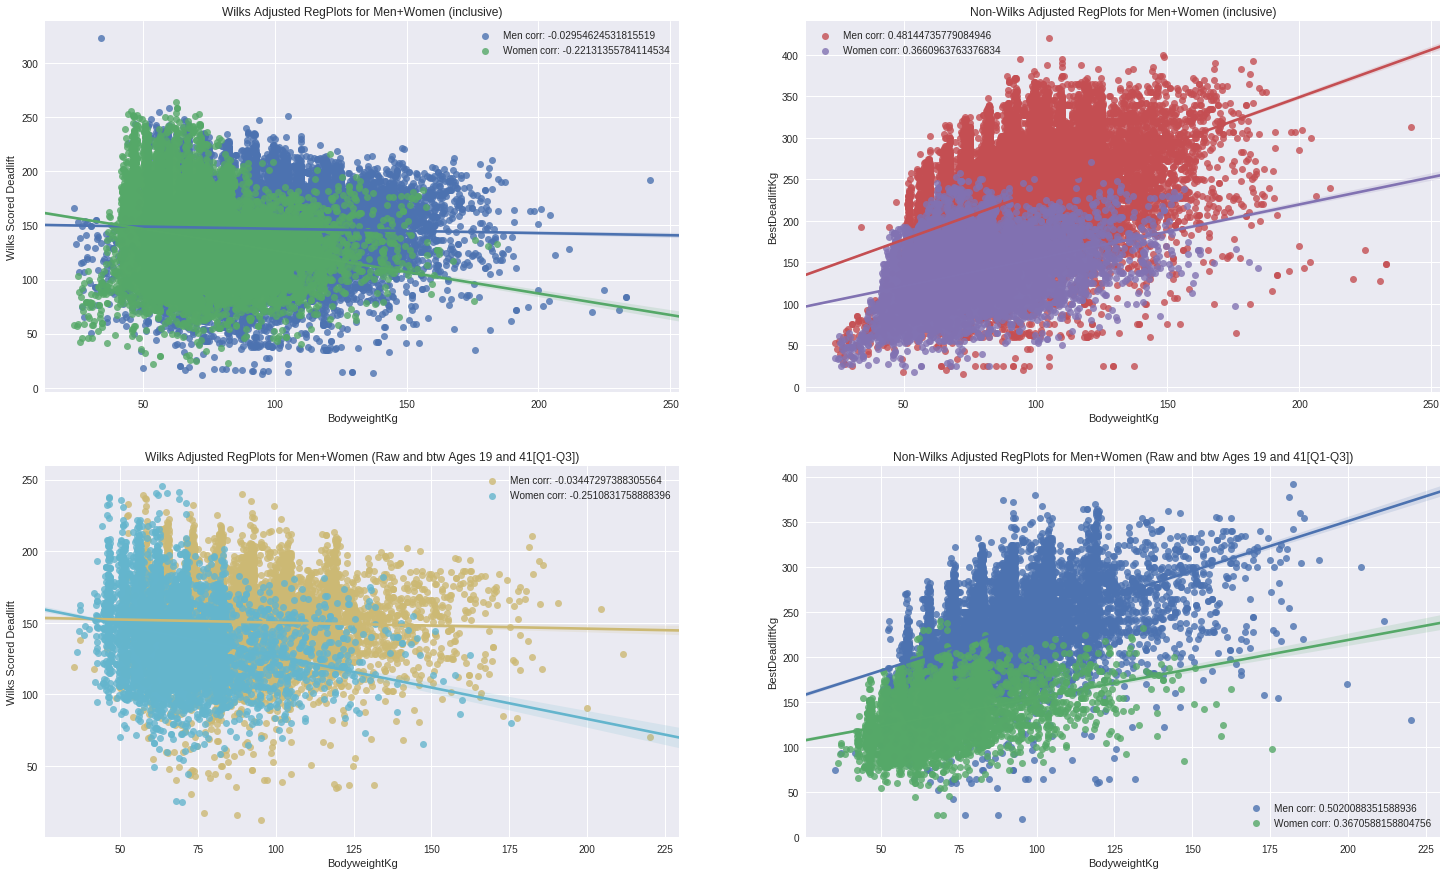

In [122]:
# Plot deadlift by wilks adjusted deadlift
deadlift = powerlifting[powerlifting['BestDeadliftKg'].isnull() == False]

# separate data into men and women 
women = deadlift[deadlift['Sex'] == 'F']
men = deadlift[deadlift['Sex'] == 'M']

# create data to plot
x = men.BodyweightKg
y = wilks(True, x, men.BestDeadliftKg)

w = women.BodyweightKg
t = wilks(False, w, women.BestDeadliftKg)

xa = men.BodyweightKg
ya = men.BestDeadliftKg

wa = women.BodyweightKg
ta = women.BestDeadliftKg

# deadlift within Q1-Q3 of Age and only Raw 

selective_mask = (deadlift['Equipment'] == 'Raw') & (deadlift['Age'] > 19) & (deadlift['Age'] < 41)
deadlift_selective = deadlift[selective_mask]

# separate data into men and women 
womena = deadlift_selective[deadlift_selective['Sex'] == 'F']
mena = deadlift_selective[deadlift_selective['Sex'] == 'M']

# create data to plot
xb = mena.BodyweightKg
yb = wilks(True, xb, mena.BestDeadliftKg)

wb = womena.BodyweightKg
tb = wilks(False, wb, womena.BestDeadliftKg)

xab = mena.BodyweightKg
yab = mena.BestDeadliftKg

wab = womena.BodyweightKg
tab = womena.BestDeadliftKg

# get correlations 
cor1m = np.corrcoef(x, y)[0][1]
cor1w = np.corrcoef(w, t)[0][1]
cor2m = np.corrcoef(xa, ya)[0][1]
cor2w = np.corrcoef(wa, ta)[0][1]
cor3m = np.corrcoef(xb, yb)[0][1]
cor3w = np.corrcoef(wb, tb)[0][1]
cor4m = np.corrcoef(xab, yab)[0][1]
cor4w = np.corrcoef(wab, tab)[0][1]

dict_of_correlations['deadlift'] = {
    'adjustedm': cor1m,
    'adjustedw': cor1w,
    'nonadjustedm': cor2m,
    'nonadjustedw': cor2w,
    'adjustedselectivem': cor3m,
    'adjustedselectivew': cor3w,
    'nonadjustedselectivem': cor4m,
    'nonadjustedselectivew': cor4w
}

# plot data

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))


sns.regplot(x, y, ax=axes[0][0], label='Men corr: {}'.format(cor1m))
sns.regplot(w, t, ax=axes[0][0], label='Women corr: {}'.format(cor1w))
axes[0][0].legend()
axes[0][0].set_ylabel("Wilks Scored Deadlift")
axes[0][0].set_title('Wilks Adjusted RegPlots for Men+Women (inclusive)')

sns.regplot(xa, ya, ax=axes[0][1], label='Men corr: {}'.format(cor2m))
sns.regplot(wa, ta, ax=axes[0][1], label='Women corr: {}'.format(cor2w))
axes[0][1].legend()
axes[0][1].set_title('Non-Wilks Adjusted RegPlots for Men+Women (inclusive)')

sns.regplot(xb, yb, ax=axes[1][0], label='Men corr: {}'.format(cor3m))
sns.regplot(wb, tb, ax=axes[1][0], label='Women corr: {}'.format(cor3w))
axes[1][0].legend()
axes[1][0].set_ylabel("Wilks Scored Deadlift")
axes[1][0].set_title('Wilks Adjusted RegPlots for Men+Women (Raw and btw Ages 19 and 41[Q1-Q3])')

sns.regplot(xab, yab, ax=axes[1][1], label='Men corr: {}'.format(cor4m))
sns.regplot(wab, tab, ax=axes[1][1], label='Women corr: {}'.format(cor4w))
axes[1][1].legend()
axes[1][1].set_title('Non-Wilks Adjusted RegPlots for Men+Women (Raw and btw Ages 19 and 41[Q1-Q3])')
plt.show()

In [158]:
# scale the axes for wilks and non wilks

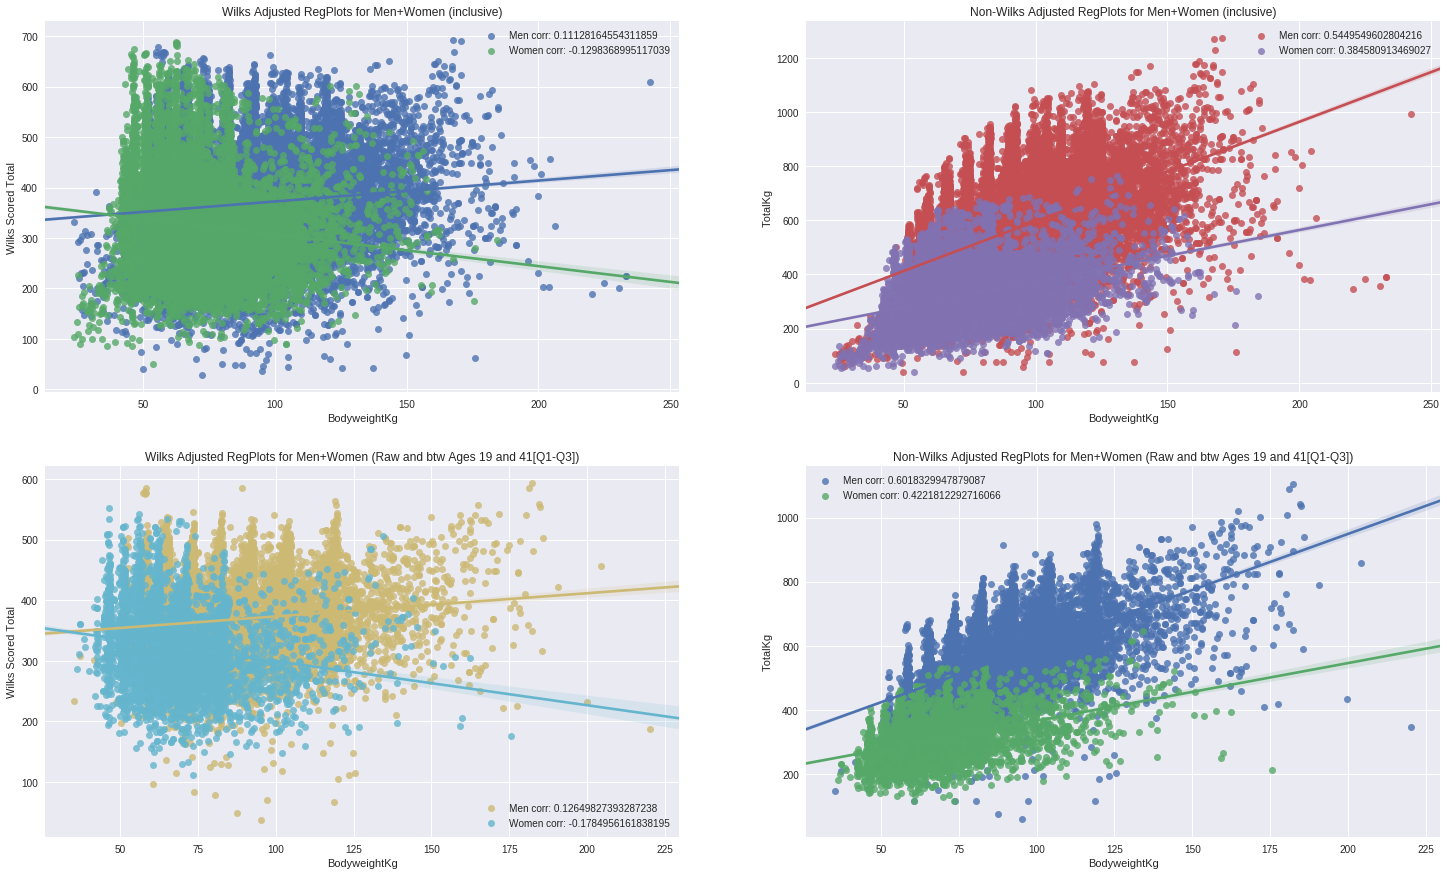

In [123]:
# Plot total by wilks adjusted total
total = powerlifting[powerlifting['TotalKg'].isnull() == False]

# separate data into men and women 
women = total[total['Sex'] == 'F']
men = total[total['Sex'] == 'M']

# create data to plot
x = men.BodyweightKg
y = wilks(True, x, men.TotalKg)

w = women.BodyweightKg
t = wilks(False, w, women.TotalKg)

xa = men.BodyweightKg
ya = men.TotalKg

wa = women.BodyweightKg
ta = women.TotalKg 

# bench within Q1-Q3 of Age and only Raw 

selective_mask = (total['Equipment'] == 'Raw') & (total['Age'] > 19) & (total['Age'] < 41)
total_selective = total[selective_mask]

# separate data into men and women 
womena = total_selective[total_selective['Sex'] == 'F']
mena = total_selective[total_selective['Sex'] == 'M']

# create data to plot
xb = mena.BodyweightKg
yb = wilks(True, xb, mena.TotalKg)

wb = womena.BodyweightKg
tb = wilks(False, wb, womena.TotalKg)

xab = mena.BodyweightKg
yab = mena.TotalKg

wab = womena.BodyweightKg
tab = womena.TotalKg 

# get correlations 
cor1m = np.corrcoef(x, y)[0][1]
cor1w = np.corrcoef(w, t)[0][1]
cor2m = np.corrcoef(xa, ya)[0][1]
cor2w = np.corrcoef(wa, ta)[0][1]
cor3m = np.corrcoef(xb, yb)[0][1]
cor3w = np.corrcoef(wb, tb)[0][1]
cor4m = np.corrcoef(xab, yab)[0][1]
cor4w = np.corrcoef(wab, tab)[0][1]

dict_of_correlations['total'] = {
    'adjustedm': cor1m,
    'adjustedw': cor1w,
    'nonadjustedm': cor2m,
    'nonadjustedw': cor2w,
    'adjustedselectivem': cor3m,
    'adjustedselectivew': cor3w,
    'nonadjustedselectivem': cor4m,
    'nonadjustedselectivew': cor4w
}

# plot data

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))


sns.regplot(x, y, ax=axes[0][0], label='Men corr: {}'.format(cor1m))
sns.regplot(w, t, ax=axes[0][0], label='Women corr: {}'.format(cor1w))
axes[0][0].legend()
axes[0][0].set_ylabel("Wilks Scored Total")
axes[0][0].set_title('Wilks Adjusted RegPlots for Men+Women (inclusive)')

sns.regplot(xa, ya, ax=axes[0][1], label='Men corr: {}'.format(cor2m))
sns.regplot(wa, ta, ax=axes[0][1], label='Women corr: {}'.format(cor2w))
axes[0][1].legend()
axes[0][1].set_title('Non-Wilks Adjusted RegPlots for Men+Women (inclusive)')

sns.regplot(xb, yb, ax=axes[1][0], label='Men corr: {}'.format(cor3m))
sns.regplot(wb, tb, ax=axes[1][0], label='Women corr: {}'.format(cor3w))
axes[1][0].legend()
axes[1][0].set_ylabel("Wilks Scored Total")
axes[1][0].set_title('Wilks Adjusted RegPlots for Men+Women (Raw and btw Ages 19 and 41[Q1-Q3])')

sns.regplot(xab, yab, ax=axes[1][1], label='Men corr: {}'.format(cor4m))
sns.regplot(wab, tab, ax=axes[1][1], label='Women corr: {}'.format(cor4w))
axes[1][1].legend()
axes[1][1].set_title('Non-Wilks Adjusted RegPlots for Men+Women (Raw and btw Ages 19 and 41[Q1-Q3])')
plt.show()